# Part C - Model
---
**Name:**       Ong Zheng Kai  
**Student ID:** p2004048  
**Class:**      DAAA 2A04  
## Links
[Dataset Used](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)   
[Stop Word List](https://github.com/igorbrigadir/stopwords/blob/21fb2ef149216e3c8cac097975223604ae1e2310/en/zettair.txt)

## Importing
- Importing necessary library
- Importing data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
news_data = pd.read_csv('news_data.csv', index_col=0)

X, y = news_data.drop(columns=['fake']), news_data['fake']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
# Basic Initialization
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
stop_list = pd.read_csv('zettair.txt', delimiter='\n', names=['stop'])['stop'].values
stop_list = frozenset(stop_list)

def pipeline(clf):
    return Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', clf)])

## Modeling Selection
- At this stage, the objectives are to not only find the best models
- We also would want to find the best features so as to not keep redundant features

In [4]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.dummy import DummyClassifier

models = {
    'SVC': SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'MultiNB': MultinomialNB(),
    'PassAgr': PassiveAggressiveClassifier(),
    'LogReg': LogisticRegression(),
    'DummyClassifier': DummyClassifier()
}

In [5]:
scores = {
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1-score': [],
    'time': []
}

trained_models = {}

for model in models.keys():
    results = cross_validate(pipeline(models[model]), x_train['title'], y_train, cv=5, scoring=scoring, n_jobs=-1)

    scores['model'].append(model)

    scores['accuracy'].append(np.mean(results['test_accuracy']))
    scores['precision'].append(np.mean(results['test_precision_weighted']))
    scores['recall'].append(np.mean(results['test_recall_weighted']))
    scores['f1-score'].append(np.mean(results['test_f1_weighted']))
    scores['time'].append(np.mean(results['fit_time'] + results['score_time']))

class_report = pd.DataFrame(scores)
print(display(class_report))

,model,accuracy,precision,recall,f1-score,time
0,SVC,0.962209,0.962400,0.962209,0.962206,168.752943
1,DecisionTree,0.918026,0.918152,0.918026,0.918022,4.487701
2,RandomForest,0.951323,0.951731,0.951323,0.951315,17.365474
3,MultiNB,0.945078,0.945672,0.945078,0.945057,0.396807
4,PassAgr,0.953250,0.953266,0.953250,0.953249,0.438283
5,LogReg,0.952929,0.953226,0.952929,0.952923,0.622749
6,DummyClassifier,0.501590,0.251593,0.501590,0.335102,0.391283


None


[]

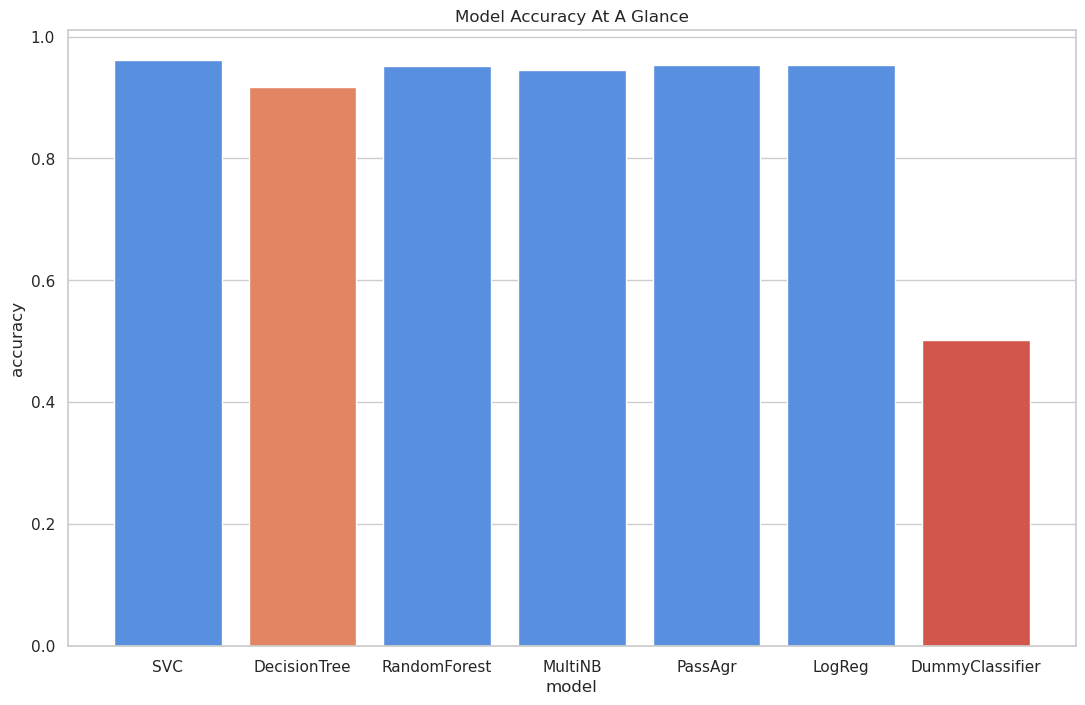

In [6]:
plt.figure(figsize=(13,8))

sb.set_theme(style='whitegrid')

plt.title('Model Accuracy At A Glance')

palette = ['#428bf5', '#f77b4d', '#428bf5', '#428bf5', '#428bf5', '#428bf5', '#ea4335']
sb.barplot(data=class_report, x='model', y='accuracy', palette=palette)

plt.plot()

#### Model Evaluation
---
Testing all models, most models yield satisfactory results. The worst performing model being Decision Tree. However, Decision Tree still vastly outperforms the stupid baseline - Dummy Classifier. All acheive accuracy scores of more than 0.9 which is good. However, any of the models selected still require hyper parameter tuning.   

#### Stupid Baseline Comparison
---
All the models outperforms the Dummy Classifier. As mentioned, even the worst performing model vastly outperforms the Stupid Baseline.

## Model Selection
---
For this project, we'll be using the Passive Aggressive Classifier.   

*Why use a Passive Aggressive Classifier?*   
As all the models have a relatively close accuracy score, we have to start evaluating 
the models by the speed of the models. We will not be choosing Decision Tree as 
it has the lowest accuracy score. Although SVC has the highest accuracy, it 
simply takes far too long to train the model, and hence we are left with Random 
Forest, Multinomial NB, Passive Aggressive Classifier and Logistic Regression. 
Passive Aggressive classifier has the second highest accuracy score and moreover, 
it is faster compared to Random Forest. Hence, Passive Aggressive will be chosen.

## Fine Tuning Model
---
As the Passive Aggressive Classifier does not have an accuracy score of 1.0, we 
will be hyper tune the model to improve the models accuracy.

In [8]:
param_grid = {
    'vect__stop_words': [None, 'english', stop_list],
    'clf__C': [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001],
    'clf__max_iter': np.arange(1000, 10000, 1000),
}

gCV = GridSearchCV(pipeline(PassiveAggressiveClassifier()), param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
searched = gCV.fit(x_train['title'], y_train)

print('Score After Parametr Tuning', -1 * searched.best_score_)
print('Best Parameters Are:', searched.best_params_) 

Fitting 5 folds for each of 189 candidates, totalling 945 fits
Score After Parametr Tuning -0.9600199291205609
Best Parameters Are: {'clf__C': 0.1, 'clf__max_iter': 3000, 'vect__stop_words': None}


In [12]:
params = {'C': 0.1, 'max_iter': 3000}

model = pipeline(PassiveAggressiveClassifier(**params))
model = model.fit(x_train['title'], y_train)

y_pred = model.predict(x_test['title'])

con_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
con_matrix = pd.DataFrame(con_matrix, columns=['p', 'e'], index=['p', 'e'])

print('Final Model')
print('Accuracy', accuracy_score(y_test, y_pred))

print('\nConfusion matrix')
print(display(con_matrix))

print('\nClassificaiton Report')
print(classification_report(y_test, y_pred))

Final Model
Accuracy 0.9603128282946188

Confusion matrix


,p,e
p,4168,170
e,170,4059


None

Classificaiton Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4338
           1       0.96      0.96      0.96      4229

    accuracy                           0.96      8567
   macro avg       0.96      0.96      0.96      8567
weighted avg       0.96      0.96      0.96      8567



## Results
After testing the Passive Aggressive Classifier with the best parameters, it performed quite well with an accuracy of 0.96.   
Now let us try to understand which words affect the models decisions to classify a news article to be real or fake.

In [22]:
tokens = np.array(model.named_steps.vect.get_feature_names())
tokens_nonzero = tokens[model.named_steps.clf.coef_[0] != 0]
weights = model.named_steps.clf.coef_[0][model.named_steps.clf.coef_[0] != 0]

indicators = pd.DataFrame({
    'token': tokens_nonzero,
    'weight': weights
})

indicators = indicators.sort_values(by=['weight'])

print('Top 10 Tokens likely to appear in real news:')
print(display(indicators.head(10)), '\n\n')

print('Top 10 Tokens likely to appear in fake news:')
print(display(indicators.tail(10)))

Top 10 Tokens likely to appear in real news:


,token,weight
5254,factbox,-7.006539
12110,says,-6.557875
14768,urges,-4.468491
11853,rohingya,-4.432834
5090,exclusive,-3.886221
9231,myanmar,-3.766333
12292,seek,-3.607736
7842,kremlin,-3.582149
2018,britain,-3.561239
14069,tillerson,-3.510540


None 


Top 10 Tokens likely to appear in fake news:


,token,weight
2163,busted,4.383711
3857,dem,4.515762
15277,whoa,4.539831
11030,racist,5.003172
6706,hillary,6.243774
7673,just,6.514467
15133,watch,7.747325
6157,gop,8.434112
1963,breaking,8.812951
14915,video,15.801865


None
